In [95]:
from datetime import datetime

import polars as pl
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from utils import lift_metric_plot

from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

In [58]:
pl_data = pl.read_csv("/Users/kurmangazykarabekov/Desktop/собесы/12Go Asia/data.csv")

In [59]:
pl_data.head(5)

bid,channel,createdon,cust_name,date_of_birth,email,email_domain_score,email_score,godate,insurance_flg,ip,isFraud,nationality,netprice_thb,p_attempts,paidon,passenger_passport_score,passenger_score,payer_country,payer_name,proxy,recent_abuse,role_id,seats,tor,useragent,usr_name,vehclass_id,vpn
i64,str,str,str,str,str,f64,f64,str,i64,str,i64,str,f64,i64,str,f64,f64,str,str,f64,f64,str,i64,f64,str,str,str,f64
6524445,"""affiliate""","""2021-05-01 00:…","""Tiffany Stephe…","""1999-07-04""","""ryanbrianna@ou…",0.0,10.0,"""2021-07-01 07:…",0,"""213.89.6.2""",0,"""SE""",115.0,0,"""2021-06-29 16:…",0.0,0.0,"""SE""","""Tiffany Stephe…",null,null,"""user""",1,null,"""Phone,sv,SEK""","""Tiffany Stephe…","""van""",null
5800338,"""affiliate""","""2021-05-01 00:…","""Amanda Cooper""","""2002-06-07""","""dustin85@gmail…",0.0,10.0,"""2021-05-29 13:…",1,"""124.106.133.17…",0,"""TH""",985.180176,0,"""2021-05-25 03:…",0.0,0.0,"""NU""",null,0.0,0.0,"""user""",1,0.0,"""Phone,en,PHP""","""Amanda Cooper""","""avia""",0.0
7897646,"""direct""","""2021-05-01 01:…","""Victoria Corte…",null,"""johnny40@gmail…",0.0,2.0,"""2021-05-10 10:…",1,"""183.88.101.237…",0,"""TH""",2400.0,7,"""2021-05-05 18:…",0.0,0.0,"""CH""","""Victoria Corte…",null,null,"""user""",2,null,"""Phone,de,THB""","""Victoria Corte…","""avia""",null
7644834,"""direct""","""2021-05-01 01:…","""Victoria Corte…","""1995-08-02""","""johnny40@gmail…",0.0,2.0,"""2021-05-10 12:…",1,"""183.88.101.237…",0,"""TH""",410.0,2,"""2021-05-06 04:…",0.0,0.0,"""CH""","""Victoria Corte…",null,null,"""user""",2,null,"""Phone,de,THB""","""Victoria Corte…","""bus""",null
7462960,null,"""2021-05-01 01:…","""Francisco Wagn…","""1989-01-16""","""margaretcastan…",0.0,5.0,"""2021-05-02 10:…",1,"""183.171.184.14…",0,"""TH""",573.537903,0,"""2021-04-27 17:…",0.0,0.0,"""NU""",null,0.0,0.0,"""user""",1,0.0,"""Phone,en,MYR""","""Francisco Wagn…","""train""",0.0


In [60]:
pl_data.shape

(3464222, 29)

In [61]:
pl_data["isFraud"].to_pandas().value_counts(normalize=True)

isFraud
0    0.997741
1    0.002259
Name: proportion, dtype: float64

**Convert date**

In [62]:
pl_data = (
    pl_data.with_columns(
        pl.col("createdon").str.strptime(
            pl.Datetime,
            format="%Y-%m-%d %H:%M:%S%z",
        )
    )
    .with_columns(
        pl.col("date_of_birth").str.strptime(
            pl.Datetime,
            format="%Y-%m-%d",
        )
    )
    .with_columns(
        pl.col("godate").str.strptime(
            pl.Datetime,
            format="%Y-%m-%d %H:%M:%S%z",
        )
    )
    .with_columns(
        pl.col("paidon").str.strptime(
            pl.Datetime, format="%Y-%m-%d %H:%M:%S.%f%z", strict=False
        )
    )
)

/var/folders/l9/p8dmtkcx40g8jtfzctxzg4km0000gn/T/ipykernel_72271/3921864125.py:21: ChronoFormatWarning: Detected the pattern `.%f` in the chrono format string. This pattern should not be used to parse values after a decimal point. Use `%.f` instead. See the full specification: https://docs.rs/chrono/latest/chrono/format/strftime
  pl.col("paidon").str.strptime(


In [63]:
pl_data = pl_data.sort("createdon", descending=False)

In [64]:
pl_data.sample(5)

bid,channel,createdon,cust_name,date_of_birth,email,email_domain_score,email_score,godate,insurance_flg,ip,isFraud,nationality,netprice_thb,p_attempts,paidon,passenger_passport_score,passenger_score,payer_country,payer_name,proxy,recent_abuse,role_id,seats,tor,useragent,usr_name,vehclass_id,vpn
i64,str,"datetime[μs, UTC]",str,datetime[μs],str,f64,f64,"datetime[μs, UTC]",i64,str,i64,str,f64,i64,"datetime[ns, UTC]",f64,f64,str,str,f64,f64,str,i64,f64,str,str,str,f64
8417836,"""direct""",2023-03-08 15:04:01 UTC,"""Karen Huang""",1994-09-25 00:00:00,"""craig06@gmail.…",0.0,10.0,2023-03-09 13:42:00 UTC,1,"""184.22.9.229""",0,"""TH""",889.0,0,2023-03-04 11:24:22.000194589 UTC,0.0,0.0,"""JP""","""KAREN HUANG""",null,null,"""user""",3,null,"""Phone,jp,JPY""","""Karen Huang""","""train""",null
7380247,"""referral""",2023-10-12 05:26:54 UTC,"""Jill Davis""",1998-07-29 00:00:00,"""eperry@hotmail…",0.0,2.0,2023-10-13 13:00:00 UTC,0,"""183.182.122.55…",0,"""TH""",550.149963,0,2023-10-10 12:58:58.000974713 UTC,0.0,0.0,"""GB""","""JILL DAVIS""",0.0,0.0,"""user""",1,0.0,"""Desktop,fr,GBP…","""Jill Davis""","""bus""",0.0
8177159,"""organic""",2023-01-01 07:26:12 UTC,"""Ashley Carson""",1999-04-13 00:00:00,"""carmenglass@gm…",0.0,0.0,2023-01-01 13:00:00 UTC,1,"""1.46.148.24""",0,"""TH""",680.0,0,2022-12-30 16:37:35.000999153 UTC,0.0,0.0,"""TH""","""Ashley Carson""",null,null,"""user""",1,null,"""Phone,th,THB""","""Ashley Carson""","""bus""",null
6890863,"""paid""",2023-02-28 15:10:15 UTC,"""Morgan Huffman…",1990-10-15 00:00:00,"""mosleymiranda@…",0.0,10.0,2023-03-03 01:30:00 UTC,0,"""175.176.75.19""",0,"""FR""",189.982056,0,2023-02-27 04:23:07.000389858 UTC,0.0,0.0,"""NU""",null,0.0,0.0,"""user""",2,0.0,"""Phone,fr,PHP""","""Teresa Frank""","""bus""",0.0
5929666,"""affiliate""",2023-01-23 15:30:12 UTC,"""Michael Le""",1988-07-11 00:00:00,"""robertfitzgera…",0.0,2.0,2023-01-25 13:30:00 UTC,1,"""49.237.10.166""",0,"""GB""",924.0,0,2023-01-22 04:27:45.000331584 UTC,0.0,0.0,"""GB""","""MICHAEL LE""",1.0,0.0,"""user""",1,0.0,"""Phone,en,GBP""","""Michael Le""","""bus""",0.0


In [65]:
pl_data.to_pandas().isna().mean()

bid                         0.000000e+00
channel                     3.410520e-02
createdon                   0.000000e+00
cust_name                   2.886651e-07
date_of_birth               1.015986e-02
email                       0.000000e+00
email_domain_score          0.000000e+00
email_score                 0.000000e+00
godate                      0.000000e+00
insurance_flg               0.000000e+00
ip                          6.697030e-05
isFraud                     0.000000e+00
nationality                 1.183527e-05
netprice_thb                0.000000e+00
p_attempts                  0.000000e+00
paidon                      1.443326e-06
passenger_passport_score    0.000000e+00
passenger_score             0.000000e+00
payer_country               2.136122e-05
payer_name                  3.743172e-01
proxy                       4.931788e-01
recent_abuse                4.931788e-01
role_id                     0.000000e+00
seats                       0.000000e+00
tor             

In [66]:
# пока пропущенные значения заполним так
pl_data = pl_data.with_columns(
    pl.col("channel").fill_null("unknown"),
    pl.col("cust_name").fill_null("unknown"),
    pl.col("date_of_birth").fill_null(strategy="min"),
    pl.col("nationality").fill_null("unknown"),
    pl.col("payer_country").fill_null("unknown"),
    pl.col("proxy").fill_null(0.0),
    pl.col("tor").fill_null(0.0),
    pl.col("vpn").fill_null(0.0),
    pl.col("recent_abuse").fill_null(0.0),
)

In [67]:
print(f"Min data of booking {pl_data['createdon'].min()}")
print(f"Max data of booking {pl_data['createdon'].max()}")

Min data of booking 2021-04-30 17:21:17+00:00
Max data of booking 2023-11-30 16:59:52+00:00


In [68]:
date_split_utc = pl.datetime(2022, 11, 30, 0, 0, 0).cast(
    pl.Datetime("us", time_zone="UTC")
)

In [69]:
pl_data.filter(pl.col("createdon") < date_split_utc)[
    "isFraud"
].to_pandas().value_counts(normalize=True)

isFraud
0    0.997879
1    0.002121
Name: proportion, dtype: float64

In [70]:
pl_data.filter(pl.col("createdon") >= date_split_utc)[
    "isFraud"
].to_pandas().value_counts(normalize=True)

isFraud
0    0.997701
1    0.002299
Name: proportion, dtype: float64

In [71]:
train_data = pl_data.filter(pl.col("createdon") < date_split_utc)
test_data = pl_data.filter(pl.col("createdon") >= date_split_utc)

In [72]:
X_train = train_data.drop(
    [
        "isFraud",
        "bid",
        "cust_name",
        "date_of_birth",
        "email",
        "godate",
        "ip",
        "paidon",
        "payer_name",
        "useragent",
        "usr_name",
        "createdon",]
).to_pandas()
y_train = train_data["isFraud"].to_pandas()

X_test = test_data.drop(
    [
        "isFraud",
        "bid",
        "cust_name",
        "date_of_birth",
        "email",
        "godate",
        "ip",
        "paidon",
        "payer_name",
        "useragent",
        "usr_name",
        "createdon",
    ]
).to_pandas()
y_test = test_data["isFraud"].to_pandas()

In [76]:
cat_features = ["channel", "nationality", "payer_country", "role_id", "vehclass_id"]

In [77]:
train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)

In [104]:
class_counts = y_train.value_counts()
total = len(y_train)

class_weights = {
    0: 1,
    1: class_counts[0] / class_counts[1]
}

In [109]:
clf = CatBoostClassifier(
    iterations=1000,
    thread_count=-1,
    random_seed=42,
    cat_features=cat_features
    )

clf.fit(
    X_train,
    y_train,
    eval_set=(X_test, y_test),
    verbose=100,
    use_best_model=True,
    early_stopping_rounds=50,
    plot=True,
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.164541
0:	learn: 0.2692691	test: 0.2622367	best: 0.2622367 (0)	total: 830ms	remaining: 13m 48s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.01313832867
bestIteration = 11

Shrink model to first 12 iterations.


In [110]:
y_pred = clf.predict(test_pool)
y_pred_proba = clf.predict_proba(test_pool)[:, 1]

In [111]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   2670628
           1       0.69      0.05      0.09      6155

    accuracy                           1.00   2676783
   macro avg       0.85      0.52      0.54   2676783
weighted avg       1.00      1.00      1.00   2676783



In [112]:
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC-AUC Score: {roc_auc:.4f}")


ROC-AUC Score: 0.8368


/Users/kurmangazykarabekov/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


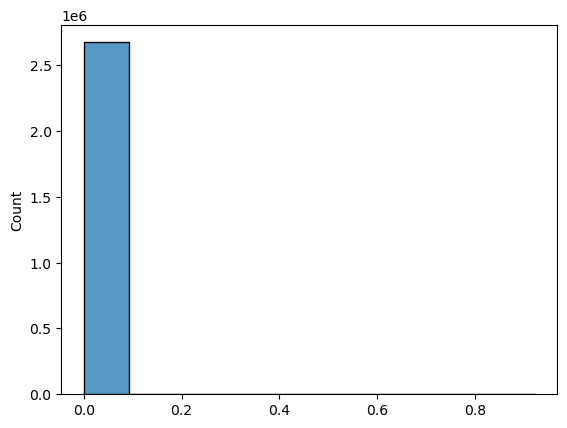

In [113]:
sns.histplot(y_pred_proba,bins=10)
plt.show()

In [117]:
clf.get_feature_importance(prettified=True)

,Feature Id,Importances
0,email_score,59.424552
1,netprice_thb,16.856477
2,proxy,7.288552
3,channel,3.537614
4,vehclass_id,3.071956
5,recent_abuse,3.001856
6,p_attempts,2.507074
7,insurance_flg,1.505536
8,nationality,1.100825
9,seats,0.750964


In [92]:
def lift_metric_plot(model, X_test, y_test):
    all_pred = pd.DataFrame()
    all_pred["prob"] = model.predict_proba(X_test)[:, 1]
    all_pred["true"] = y_test.values
    import matplotlib.pyplot as plt
    import numpy as np
    from sklearn.metrics import precision_score
    from sklearn.metrics import recall_score
    from sklearn.metrics import f1_score
    from sklearn.metrics import accuracy_score

    y_true = all_pred["true"]
    recall = []
    precision = []
    score = []
    f_score = []

    aa = -np.sort(
        -all_pred["prob"].describe(percentiles=np.linspace(0, 1, 101))[4:105].values
    )
    for i in range(0, len(aa)):
        f = lambda x: 1 if x >= aa[i] else 0
        score.append(aa[i])
        y_pred = all_pred["prob"].map(f)
        g = recall_score(y_true, y_pred, average="binary")
        recall.append(g)
        p = precision_score(y_true, y_pred, average="binary")
        precision.append(p)
        t = f1_score(y_true, y_pred, average="binary")
        f_score.append(t)

    temp = pd.DataFrame()
    temp["score"] = score
    temp["recall"] = recall
    temp["precision"] = precision
    temp["top_percentile"] = np.round(list(np.linspace(0, 100, 101))).tolist()

    temp["lift"] = temp["recall"] / (temp["top_percentile"] / 100.0)
    temp["max_lift"] = 1 / (y_test.sum() / len(y_test))
    temp["relative_lift"] = temp["lift"] / temp["max_lift"]

    temp["percent"] = 100 * (y_test.sum() / len(y_test))
    plt.figure()
    plt.plot(temp[1:]["top_percentile"], temp[1:]["lift"])
    plt.xlabel("Percentile")
    plt.ylabel("LIFT")
    plt.scatter(
        1,
        temp[temp["top_percentile"] == 1]["lift"][1],
        marker="o",
        s=30,
        zorder=10,
        color="b",
    )
    plt.text(
        1,
        temp[temp["top_percentile"] == 1]["lift"][1],
        "      top 1 : {}".format(
            np.round(temp[temp["top_percentile"] == 1]["lift"][1], 3)
        ),
        fontsize=10,
    )
    plt.scatter(
        10,
        temp[temp["top_percentile"] == 10]["lift"][10],
        marker="o",
        s=30,
        zorder=10,
        color="b",
    )
    plt.text(
        10,
        temp[temp["top_percentile"] == 10]["lift"][10],
        "      top 10 : {}".format(
            np.round(temp[temp["top_percentile"] == 10]["lift"][10], 3)
        ),
        fontsize=10,
    )
    plt.title("Lift-chart")
    plt.figure()
    plt.plot(temp[1:]["top_percentile"], temp[1:]["relative_lift"])
    plt.xlabel("Percentile")
    plt.ylabel("Relative_lift")
    plt.scatter(
        1,
        temp[temp["top_percentile"] == 1]["relative_lift"][1],
        marker="o",
        s=30,
        zorder=10,
        color="b",
    )
    plt.text(
        1,
        temp[temp["top_percentile"] == 1]["relative_lift"][1],
        "      top 1 : {}".format(
            np.round(temp[temp["top_percentile"] == 1]["relative_lift"][1], 3)
        ),
        fontsize=10,
    )
    plt.scatter(
        10,
        temp[temp["top_percentile"] == 10]["relative_lift"][10],
        marker="o",
        s=30,
        zorder=10,
        color="b",
    )
    plt.text(
        10,
        temp[temp["top_percentile"] == 10]["relative_lift"][10],
        "      top 10 : {}".format(
            np.round(temp[temp["top_percentile"] == 10]["relative_lift"][10], 3)
        ),
        fontsize=10,
    )
    plt.title("Relative-lift-chart")
    plt.figure()
    plt.plot(temp[1:]["top_percentile"], temp[1:]["recall"])
    plt.xlabel("Percentile")
    plt.ylabel("GAIN")
    plt.scatter(
        10,
        temp[temp["top_percentile"] == 10]["recall"][10],
        marker="o",
        s=30,
        zorder=10,
        color="b",
    )
    plt.text(
        10,
        temp[temp["top_percentile"] == 10]["recall"][10],
        "      top 10 : {}".format(
            np.round(temp[temp["top_percentile"] == 10]["recall"][10], 3)
        ),
        fontsize=10,
    )
    plt.scatter(
        40,
        temp[temp["top_percentile"] == 40]["recall"][40],
        marker="o",
        s=30,
        zorder=10,
        color="b",
    )
    plt.text(
        40,
        temp[temp["top_percentile"] == 40]["recall"][40],
        "      top 40 : {}".format(
            np.round(temp[temp["top_percentile"] == 40]["recall"][40], 3)
        ),
        fontsize=10,
    )
    plt.title("Gain-chart")
    from sklearn.metrics import roc_curve, auc

    fpr, tpr, thresholds = roc_curve(y_test.values, model.predict_proba(X_test)[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(
        fpr, tpr, color="darkorange", lw=1, label="ROC curve (area = %0.2f)" % roc_auc
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=1, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic (ROC)")
    plt.legend(loc="lower right")
    plt.show()
    print(temp[1:].head(10))
    return temp[1:]

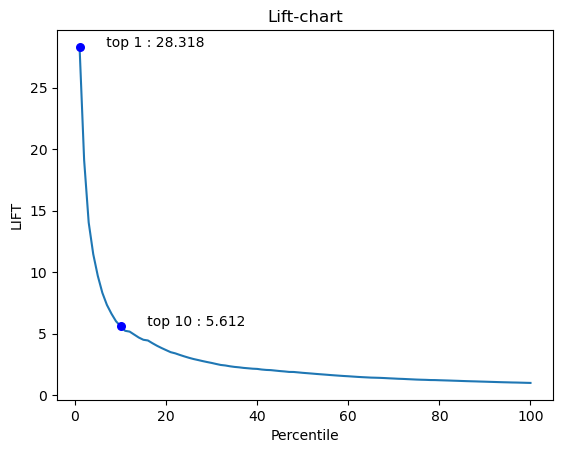

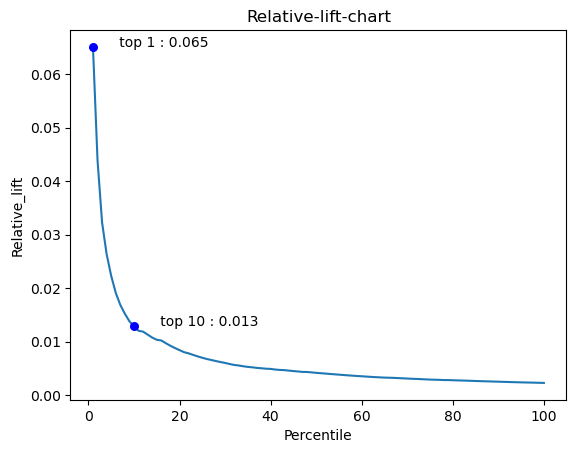

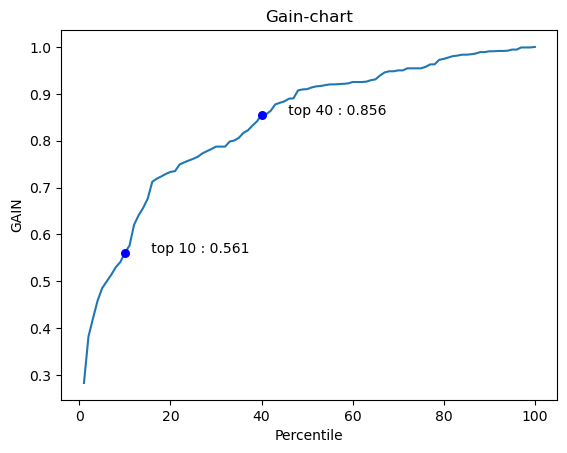

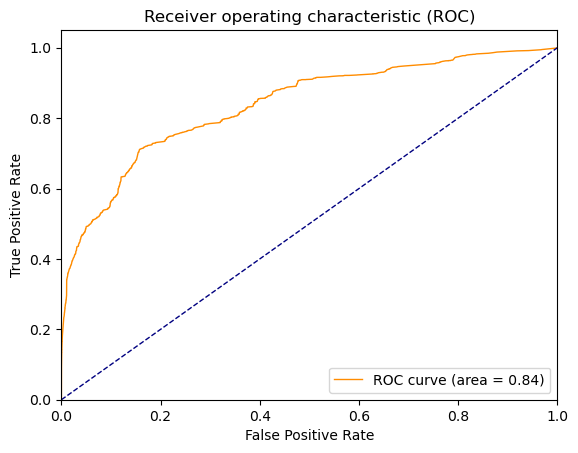

       score    recall  precision  top_percentile       lift    max_lift  \
1   0.025703  0.283184   0.064837             1.0  28.318440  434.895695   
2   0.015681  0.382453   0.043882             2.0  19.122665  434.895695   
3   0.012453  0.421446   0.032249             3.0  14.048199  434.895695   
4   0.009870  0.458814   0.026272             4.0  11.470349  434.895695   
5   0.007969  0.485297   0.022318             5.0   9.705930  434.895695   
6   0.006893  0.499756   0.019119             6.0   8.329272  434.895695   
7   0.005901  0.514054   0.016796             7.0   7.343623  434.895695   
8   0.004990  0.530138   0.015076             8.0   6.626726  434.895695   
9   0.004464  0.541186   0.013270             9.0   6.013178  434.895695   
10  0.003901  0.561170   0.012903            10.0   5.611698  434.895695   

    relative_lift  percent  
1        0.065115  0.22994  
2        0.043971  0.22994  
3        0.032302  0.22994  
4        0.026375  0.22994  
5        0.022318 

,score,recall,precision,top_percentile,lift,max_lift,relative_lift,percent
1,0.025703,0.283184,0.064837,1.0,28.318440,434.895695,0.065115,0.22994
2,0.015681,0.382453,0.043882,2.0,19.122665,434.895695,0.043971,0.22994
3,0.012453,0.421446,0.032249,3.0,14.048199,434.895695,0.032302,0.22994
4,0.009870,0.458814,0.026272,4.0,11.470349,434.895695,0.026375,0.22994
5,0.007969,0.485297,0.022318,5.0,9.705930,434.895695,0.022318,0.22994
...,...,...,...,...,...,...,...,...
96,0.000228,0.994314,0.002364,96.0,1.035743,434.895695,0.002382,0.22994
97,0.000227,0.998863,0.002308,97.0,1.029755,434.895695,0.002368,0.22994
98,0.000227,0.998863,0.002308,98.0,1.019248,434.895695,0.002344,0.22994
99,0.000227,0.998863,0.002308,99.0,1.008952,434.895695,0.002320,0.22994


In [93]:
lift_metric_plot(clf, X_test, y_test)